In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [3]:
root_dir = os.getcwd()

In [4]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [5]:
def vol_category_helper(row, *args):
    q0, q1, q2, q3 = args
    if row <= q0:
        return 0
    elif row <= q1:
        return 1
    elif row <= q2:
        return 2
    elif row <= q3:
        return 3
    else:
        return 3

In [6]:
def beta_helper(row, *args):
    spy = args[0]
    try:
        return pd.Series(dict(beta=(row['corr'] * row['vol']) / spy.loc[row['Date'], 'vol'],
                              market_log_return=spy.loc[row['Date'], 'log_return']))
    except KeyError:
        return pd.Series(dict(beta=np.nan, market_log_return=np.nan))

In [7]:
def corr_helper(row, *args):
    correl = args[0]
    try:
        return correl['SPY'][row.Date][row.ticker]
    except KeyError:
        return np.nan

In [8]:
def calc_momentum(combined, fast_window=7, slow_window=25):
    for ticker in combined['ticker'].unique():
        combined.loc[combined['ticker'] == ticker, 'fast'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()

        combined.loc[combined['ticker'] == ticker, 'slow'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
    return pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])

In [9]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    tickers = os.listdir(root_dir+'/data/equities') + os.listdir(root_dir+'/data')
    for ticker in tickers:
        if '.csv' in ticker:
            try:
                df = pd.read_csv(root_dir+'/data/equities/{}'.format(ticker))
            except FileNotFoundError:
                df = pd.read_csv(root_dir+'/data/{}'.format(ticker))
            df = df.replace({'null': np.nan})
            df['Close'] = pd.to_numeric(df['Close'])
            df['ticker'] = ticker[:-4]
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date', False)
            df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
            df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)

            # Calculate vol on a 1 year rolling basis
            df['vol'] = df['pct_change'].rolling(252).std()
            df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
            df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
            out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    
    gb_equity = pd.DataFrame()
    for key, grp in combined.groupby('ticker'):
        gb_equity[key] = grp['log_return']
    correl = gb_equity.rolling(252).corr()
    combined['corr'] = combined.apply(corr_helper, axis=1, args=(correl, ))
    combined['beta'] = 0
    combined['market_log_return'] = 0
    combined.loc[:, ['beta', 'market_log_return']] = combined.apply(beta_helper, axis=1,
                                                             args=(combined.loc[combined.ticker == 'SPY'], ))
    combined['alpha'] = combined['log_return'] - (combined['market_log_return'] * combined['beta'])
    combined['market_log_return_shift'] = combined['market_log_return'].shift(1)
    combined['beta_abs'] = combined['beta'].abs()
    combined['ra_return'] = combined['month_log_return'] / combined['beta_abs']
    for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'ra_month_return'] = pd.rolling_sum(grp['ra_return'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
    q0, q1, q2, q3 = combined['vol'].quantile([.2, .4, .6, .8])
    # Equities are placed into 4 vol categories based on their moment-in-time volatility relative to all historical
    # observed vols
    combined['category'] = combined['vol'].apply(vol_category_helper, args=(q0, q1, q2, q3))
    combined['momentum'] = calc_momentum(combined)
    return out, combined
        

In [10]:
try:
    combined = pd.read_pickle('combined.pkl')
except:
    prices, combined = build_prices_dfs()
    pd.to_pickle(combined, 'combined.pkl')

In [11]:
combined.dropna().groupby('category').mean()

,Close,pct_change,log_return,vol,month_return,month_log_return,corr,beta,market_log_return,alpha,beta_abs,ra_return,ra_month_return,fast,slow,momentum,value
category,,,,,,,,,,,,,,,,,
0,87.572247,0.000132,0.000106,0.006691,0.002824,0.002179,0.417650,0.443211,0.000330,-0.000043,0.502100,0.019376,0.436522,87.542704,83.125253,0.001253,0.067398
1,64.812067,0.000382,0.000308,0.011864,0.007644,0.005910,0.604184,0.820962,0.000327,0.000063,0.826102,-0.000378,-0.070660,64.759470,58.493774,0.003054,0.126589
2,50.871326,0.000387,0.000256,0.015901,0.009648,0.006620,0.581065,0.929924,0.000287,-0.000038,0.930837,-0.013933,-0.250971,50.832269,46.170066,0.002828,0.145553
3,54.626097,0.000569,0.000071,0.030158,0.012187,0.001265,0.446679,0.986825,0.000233,-0.000112,1.178734,-0.002406,-0.054721,54.971333,164.698858,0.000705,0.055476


In [14]:
combined['market_log_return_shift'] = combined['market_log_return'].shift(1)

In [17]:
combined['beta_times_spy'] = combined['beta'] * combined['market_log_return_shift']

In [18]:
combined.loc[combined['ticker']!='SPY', ['beta_times_spy', 'value', 'vol', 'category', 'momentum', 'month_log_return', 'alpha', 'beta', 'beta_abs', 'market_log_return_shift', 'ra_month_return']].corr()

,beta_times_spy,value,vol,category,momentum,month_log_return,alpha,beta,beta_abs,market_log_return_shift,ra_month_return
beta_times_spy,1.000000,0.031625,-0.000819,0.000873,0.013093,-0.011887,-0.000374,0.017102,-0.001839,0.827898,-0.000255
value,0.031625,1.000000,-0.148871,-0.014606,0.261573,0.020382,-0.000173,0.253679,-0.018260,0.023162,-0.001339
vol,-0.000819,-0.148871,1.000000,0.792745,-0.001151,-0.001049,0.000940,0.284532,0.550753,-0.003003,-0.010185
category,0.000873,-0.014606,0.792745,1.000000,-0.007214,-0.005780,-0.002190,0.310873,0.483420,-0.004015,-0.014810
momentum,0.013093,0.261573,-0.001151,-0.007214,1.000000,0.019058,-0.001819,0.065413,-0.022359,0.010787,0.001224
month_log_return,-0.011887,0.020382,-0.001049,-0.005780,0.019058,1.000000,0.183831,0.067909,-0.027481,-0.014251,0.015788
alpha,-0.000374,-0.000173,0.000940,-0.002190,-0.001819,0.183831,1.000000,0.005748,-0.005043,0.005308,0.004058
beta,0.017102,0.253679,0.284532,0.310873,0.065413,0.067909,0.005748,1.000000,0.261826,-0.002998,-0.001284
beta_abs,-0.001839,-0.018260,0.550753,0.483420,-0.022359,-0.027481,-0.005043,0.261826,1.000000,-0.001844,-0.002433
market_log_return_shift,0.827898,0.023162,-0.003003,-0.004015,0.010787,-0.014251,0.005308,-0.002998,-0.001844,1.000000,-0.002797


In [120]:
combined.describe()

,Close,pct_change,log_return,vol,month_return,month_log_return,category
count,150179.000000,150158.000000,150157.000000,144952.000000,149696.000000,149695.000000,150180.000000
mean,29.127688,0.000641,0.000346,0.021647,0.014163,0.007669,3.601025
std,35.577947,0.024312,0.024332,0.010901,0.108709,0.109277,0.631584
min,0.107422,-0.518692,-0.731247,0.006040,-0.905597,-1.152158,1.000000
25%,4.656250,-0.010288,-0.010341,0.013710,-0.038860,-0.043133,3.000000
50%,15.927500,0.000000,0.000000,0.018837,0.013287,0.009782,4.000000
75%,38.812500,0.010870,0.010811,0.026708,0.066023,0.061655,4.000000
max,252.889999,0.522901,0.420617,0.082238,1.471956,1.295104,4.000000


In [121]:
def vol_category_helper(row):
    if row <= q1:
        return 1
    elif row <= q2:
        return 2
    elif row <= q3:
        return 3
    else:
        return 4

In [122]:
combined['category'] = combined['vol'].apply(vol_category_helper)

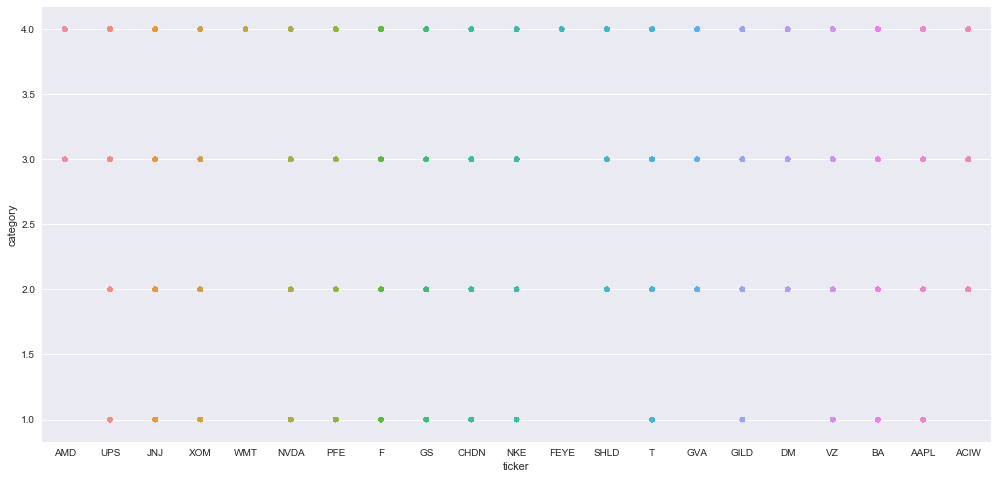

In [123]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(y='category', x='ticker', data=combined, ax=ax)

In [124]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
# asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [125]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
# combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,category,category_enc,security_enc
Date,,,,,,,,,,,,,,,
2017-07-31,79.82,80.34,79.69,79.989998,79.49,6263200,WMT,0.006376,0.006356,NaN,-0.014994,-0.015623,4,0,4
2017-08-01,80.25,80.73,80,80.500000,79.9968,5726500,WMT,0.000373,0.000373,NaN,NaN,NaN,4,0,4
2017-08-02,80.34,81.11,80.3,80.529999,80.0266,8673000,WMT,0.004222,0.004213,NaN,NaN,NaN,4,0,4
2017-08-03,81.34,81.76,80.67,80.870003,80.3645,9946900,WMT,-0.004823,-0.004834,NaN,NaN,NaN,4,0,4
2017-08-04,81.06,81.4,80.21,80.480003,79.9769,7141800,WMT,0.009940,0.009891,NaN,NaN,NaN,4,0,4
2017-08-07,80.57,81.45,80.54,81.279999,80.7719,5484500,WMT,0.003814,0.003807,NaN,NaN,NaN,4,0,4
2017-08-08,81.17,81.86,80.9,81.589996,81.08,7381400,WMT,0.000245,0.000245,NaN,NaN,NaN,4,0,4
2017-08-09,81.11,81.99,80.9,81.610001,81.61,6606500,WMT,-0.011641,-0.011709,NaN,NaN,NaN,4,0,4
2017-08-10,81.07,81.4,80.55,80.660004,80.66,8045000,WMT,-0.003223,-0.003229,NaN,NaN,NaN,4,0,4


In [126]:
combined.groupby('ticker').mean()[['vol', 'category_enc']].sort_values('vol')

,vol,category_enc
ticker,,
UPS,0.012827,2.443849
XOM,0.013646,2.459293
JNJ,0.013883,2.293555
VZ,0.014507,2.277510
T,0.014661,2.248268
PFE,0.017079,1.880224
BA,0.019578,1.540608
F,0.020539,1.480943
NKE,0.020775,1.323729


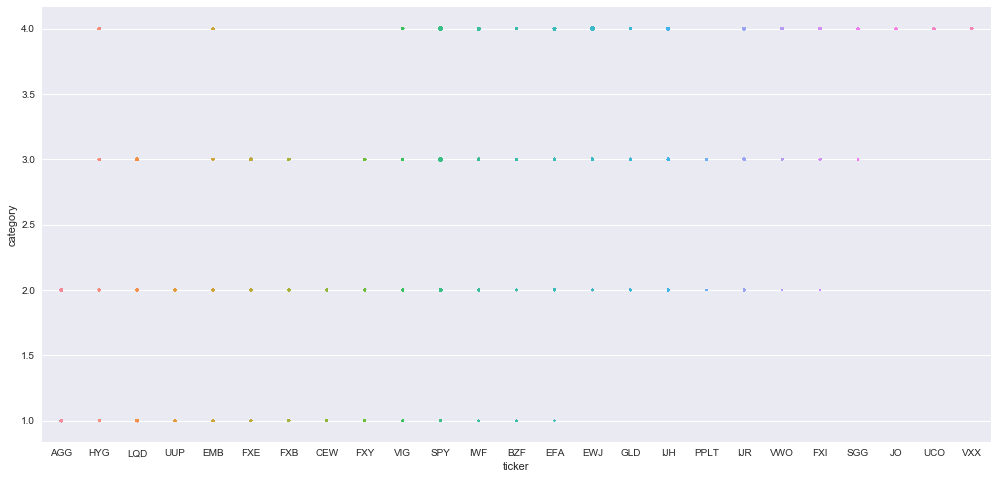

In [94]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined.sort_values('vol')['vol']*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [128]:
combined = combined.dropna()

In [31]:
combined.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ticker',
       'pct_change', 'log_return', 'vol', 'month_return', 'month_log_return',
       'corr', 'beta', 'market_log_return', 'alpha', 'beta_abs', 'ra_return',
       'ra_month_return', 'category', 'fast', 'slow', 'momentum', 'value',
       'security_enc'],
      dtype='object')

In [130]:
groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map

array([0, 1, 0, 1, 2, 3, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 0, 1, 2, 0, 1, 2, 3, 0,
       1, 2, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2])

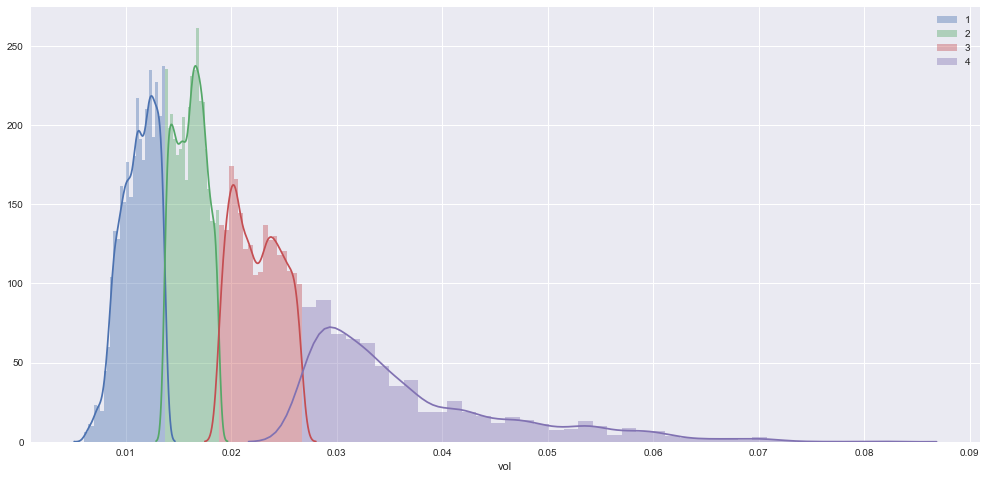

In [177]:
fig, ax = plt.subplots(figsize=(17, 8))
legend = []
for key, grp in combined.groupby('category'):
#     sns.distplot(grp['vol'], ax=ax)
    sns.distplot(grp['vol'], ax=ax)
    legend.append(key)
plt.legend(legend)

In [12]:
for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'alpha_month'] = pd.rolling_sum(grp['alpha'][::-1], window=22,
                                                                                    min_periods=22)[::-1]

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=22,min_periods=22).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


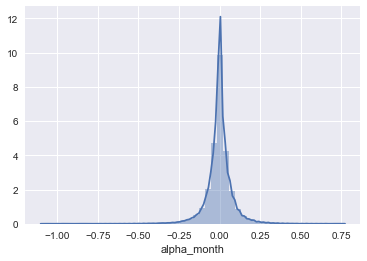

In [14]:
sns.distplot(combined['alpha_month'].dropna())

In [32]:
try:
    combined = pd.read_pickle('combined.pkl')
except:
    prices, combined = build_prices_dfs()
    pd.to_pickle(combined, 'combined.pkl')

    
for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'alpha_month'] = pd.rolling_sum(grp['alpha'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
combined['category'] = pd.qcut(combined['vol'], 10, labels=range(10))
combined = combined.dropna()
# combined = combined.iloc[np.random.choice(len(combined), 50000), :]

# asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

# combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map
# n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.5)

with pm.Model() as model:
    a_mu = pm.Normal('a_mu', mu=0, sd=5)
    a_sd = pm.Uniform('a_sd', 1, 5)
    a_mom = pm.Normal('a_mom', mu=a_mu, sd=a_sd, shape=n_categories)
    a_beta = pm.Normal('a_beta', mu=0, sd=5)
    
    b_mu = pm.Normal('b_mu', mu=0, sd=3)
    b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.Normal('b_security', mu=b_mu, sd=b_sd, shape=n_categories)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (train['momentum'].values * a_mom[train['category'].values] + 
             train['beta_abs'].values * a_beta +
             b_sec[train['category'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['alpha_month'].values)
    trace = pm.sample(500, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=22,min_periods=22).sum()
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 500/500 [40:17<00:00,  2.68it/s]  


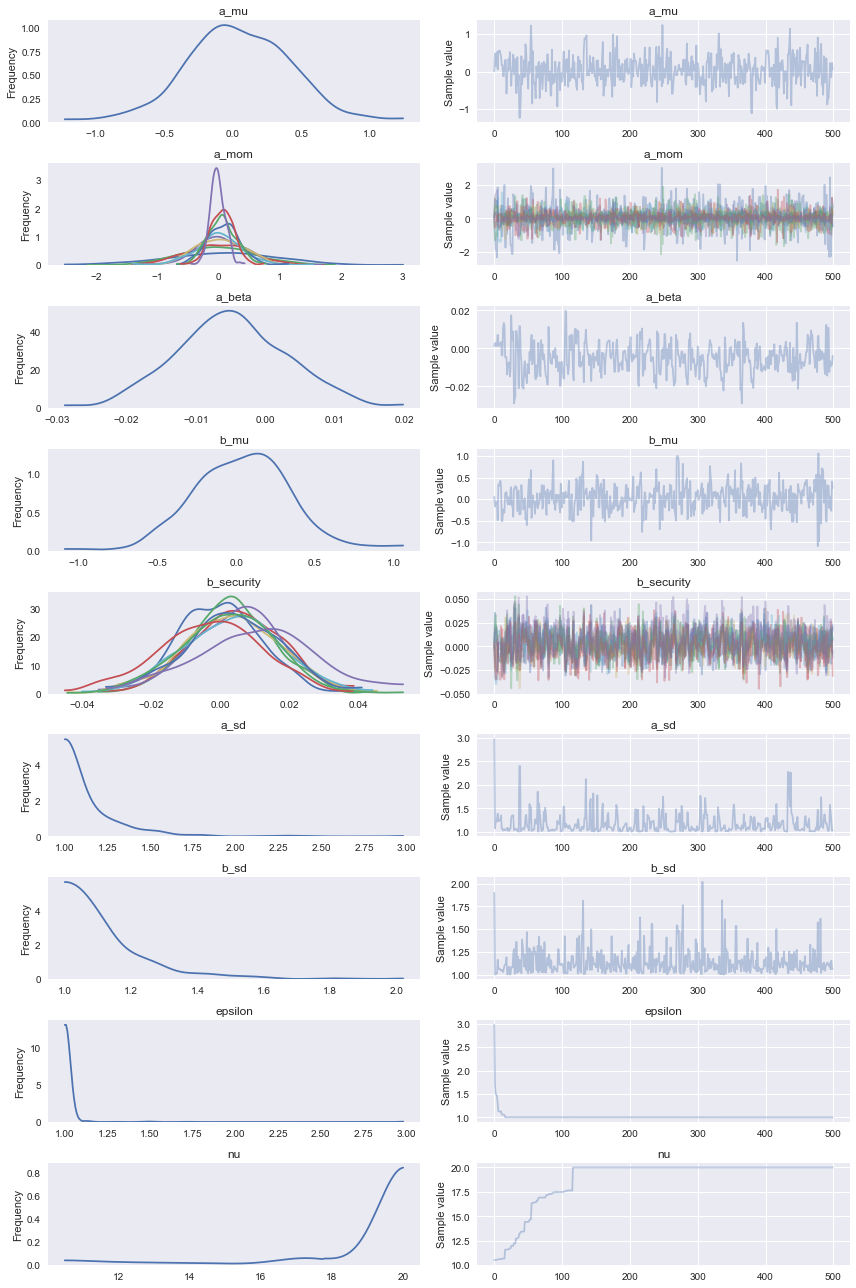

In [34]:
pm.traceplot(trace);

In [35]:
def calc_prediction_helper(row):
    a = (row.momentum * trace['a_mom'][:, row.category] +
         row.beta_abs * trace['a_beta'] +
         trace['b_security'][:, row.category])
    return np.mean(a > 0)

In [36]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1)

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


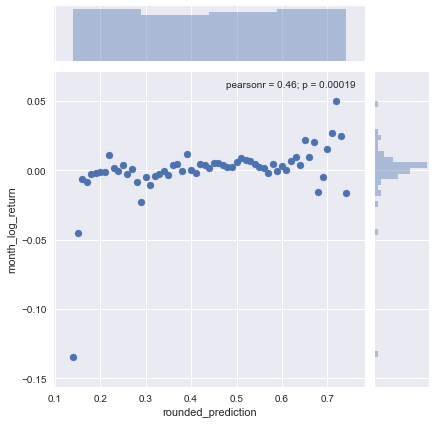

In [37]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['month_log_return'].index,
              test.groupby('rounded_prediction').mean()['month_log_return'])

In [38]:
for key, grp in test.groupby('category'):
    low, high = (.45, .55)#grp['prediction'].quantile([.25, .75])
    print('Avg. return on long positions for category {}: {}'.format(key, grp.loc[grp.prediction >= high, 'month_log_return'].mean()))
    print('Avg. return on short positions for category {}: {}\n'.format(key, grp.loc[grp.prediction <= low, 'month_log_return'].mean()))

Avg. return on long positions for category 0: nan
Avg. return on short positions for category 0: -0.0009034607713313464

Avg. return on long positions for category 1: 0.0009950009194538306
Avg. return on short positions for category 1: 0.004169631743834139

Avg. return on long positions for category 2: 0.0021633541714592363
Avg. return on short positions for category 2: 0.014119636605613871

Avg. return on long positions for category 3: 0.0038274260825167205
Avg. return on short positions for category 3: 0.006898711951884718

Avg. return on long positions for category 4: -0.000919828279270552
Avg. return on short positions for category 4: 0.0013273422176111513

Avg. return on long positions for category 5: -0.0010585979790014315
Avg. return on short positions for category 5: 0.007692661646915459

Avg. return on long positions for category 6: 0.0012642984630903888
Avg. return on short positions for category 6: 0.006198282897506175

Avg. return on long positions for category 7: -0.015974

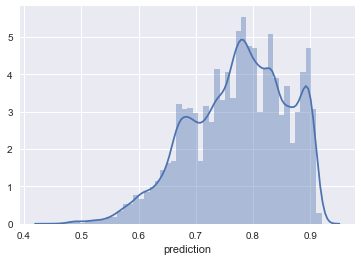

In [233]:
sns.distplot(combined['prediction'])

In [54]:
s = '['
for a in trace['a_mom']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[0.0, 0.0, 0.0332182921445, 0.0354045000097, 0.0395407204594, 0.0922857904276, 0.090407202631, 0.157201693016, 0.125452197142, 0.0943859025785, 0.113102551794, 0.141816530255, 0.111149291722, 0.0621167961445, 0.0535364431138, 0.0248846814445, -0.0302334351136, -0.0349357541535, -0.0575418704746, -0.0611935769644, -0.025159807369, -0.0246242904954, -0.0339441011669, -0.0548254381407, -0.0419675029487, -0.0318377197272, -0.0244916992602, -0.063225152605, -0.0923499974406, -0.0969040988676, -0.112339063082, -0.115888457285, -0.109204035327, -0.0983932056321, -0.111649036828, -0.109701795067, -0.1792984708, -0.180498058572, -0.197717816934, -0.197717816934, -0.248544518711, -0.575698433091, -0.578547860028, -0.56006611755, -0.516075171448, 0.107033758774, 0.0770597755707, 0.0765192182412, 0.0765192182412, 0.145834474759, -0.00735496619901, -0.0357829476989, -0.0531843635567, -0.0531843635567, 0.277361503587, 0.15754005444, 0.0302213012909, 0.0601149619007, 0.0601149619007, -0.0934745946686

In [55]:
s = '['
for a in trace['a_vol']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[0.0, 0.0, -0.0865671107916, -0.0887115685114, -0.04528750228, -0.00100313704139, 0.00953960362198, -0.261122510562, -0.330338126377, -0.350587719009, -0.346961079965, -0.382882988767, -0.441804288082, -0.389340127678, -0.416569042603, -0.501991361493, -0.550107164907, -0.568434362108, -0.562642825319, -0.585270704277, -0.599353776205, -0.597063638002, -0.610879377982, -0.66459613065, -0.666510392502, -0.63438292476, -0.626694365229, -0.568361777197, -0.595823855042, -0.601250745036, -0.226219573824, -0.222896806527, -0.252368911112, -0.322175897641, -0.325585114009, -0.239669743001, -0.241404384223, -0.25197220348, -0.264373587421, -0.264373587421, -0.209839869868, -0.905803635028, -0.919888177022, -0.936008534701, -0.625991984214, 0.893518108451, 0.79983400768, 0.436925161285, 0.436925161285, 0.382252514154, 0.0915284084386, 0.0880654666982, 0.335514269673, 0.335514269673, 0.331518273701, 0.87880696783, 0.640963555805, 0.624185592465, 0.624185592465, 0.189741598777, 0.131763503421, 1

In [219]:
s = '['
for a in np.transpose(trace['b_security']):
    s += '['
    for v in a:
        s += str(v) + ', '
    s = s[:-2] + '], '
s = s[:-2]
s += ']'
print(s)

[[0.00548856588369, 0.0200991865663, 0.0452470053991, 0.0230040370926, 0.00618432228427, 0.0112205086066, 0.00612034264962, 0.0179533899684, 0.00167273718004, 0.0174159080971, 0.00962579235517, 0.00820383735935, 0.00546850582597, -0.00123205373008, -0.00123205373008, 0.0057686719813, 0.0174162303111, 0.0174162303111, -0.00106313898925, 0.010949822637, -0.00861094572295, 0.0221186558201, 0.00230411547556, 0.00230411547556, 0.0234329313967, -0.00583099103411, -0.00941530596289, 0.026084319402, -0.00725466353437, 0.0235099288723, -0.00797958853816, -0.00249097626283, -0.00249097626283, 0.0143058088809, 0.011294104652, 0.00482982976159, 0.0138667034852, 0.0126285288606, 0.00821399728329, 0.00560732261287, 0.0260125522691, 0.00240613848586, 0.00767280049493, 0.00594895235887, 0.00594895235887, 0.013794384762, 0.0135704919991, 0.0154095343352, 0.000384707314094, 0.000384707314094, 0.00897507328738, 0.00366573676141, 0.0186839851406, -0.00623852109971, -0.00623852109971, -0.00506267687024, 0.

In [220]:
s = '['
for a in np.transpose(trace['a_mom']):
    s += '['
    for v in a:
        s += str(v) + ', '
    s = s[:-2] + '], '
s = s[:-2]
s += ']'
print(s)

[[-0.523686323478, -0.331613742371, -0.937671112621, -0.536470864817, -0.260347727508, 0.607497499516, 0.466789296282, -0.407631884597, 0.465854267348, -0.373707498203, 0.0599233145218, 0.22297294848, -0.459865710936, 0.574222992297, 0.574222992297, 0.0330285682952, -0.0104582137492, -0.0104582137492, 0.427173334646, -0.419639296875, 0.233361884599, -0.0965733777735, 0.618660907051, 0.618660907051, -0.215769351579, 0.343499856271, 0.276479371282, -0.0738756927046, 0.414846931944, -0.347475103789, 0.489677782542, 0.550660211875, 0.550660211875, -0.0540118685497, -0.344254824611, -0.0475643707721, 0.377360286724, 0.214267775229, 0.227155805554, 0.247975803368, -0.0563221520031, 0.356480465793, -0.0710955738031, 0.420521985365, 0.420521985365, -0.287937339301, -0.102281948418, 0.246608975432, -0.112123882018, -0.112123882018, 0.328791194645, -0.332783127875, -0.0860744413153, 0.335833684495, 0.335833684495, 0.260605839006, 0.153414316465, -0.0484231863567, -0.223979767425, 0.125223340355,

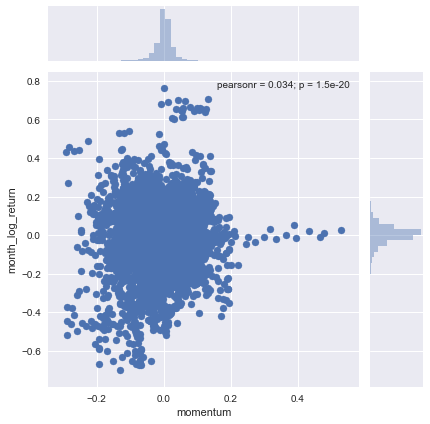

In [451]:
sns.jointplot('momentum', 'month_log_return', data=combined)

In [44]:
test['prediction'].describe()

count    77040.000000
mean         0.470014
std          0.098142
min          0.142000
25%          0.428000
50%          0.480000
75%          0.530000
max          0.736000
Name: prediction, dtype: float64

In [48]:
test['position'] = 0
test.loc[test.prediction >= .6, 'position'] = 1
test.loc[test.prediction <= .4, 'position'] = -1
test['bt_return'] = test['log_return'] * test['position']
test['date'] = test.index

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [49]:
test.groupby('position').mean()

,Close,pct_change,log_return,vol,month_return,month_log_return,corr,beta,market_log_return,alpha,...,ra_month_return,fast,slow,momentum,value,alpha_month,security_enc,prediction,rounded_prediction,bt_return
position,,,,,,,,,,,,,,,,,,,,,
-1,67.008393,0.000557,0.000195,0.025955,0.007201,-0.000996,0.496907,0.993186,0.000402,-0.000218,...,0.002176,67.334645,200.233624,-0.015121,0.043855,-0.006556,20.410232,0.309573,0.309616,-0.000195
0,64.995500,0.000339,0.000189,0.015056,0.007341,0.003938,0.512602,0.775209,0.000244,0.000040,...,0.106123,65.054057,82.909340,0.007501,0.110607,-0.000512,21.967959,0.491245,0.491243,0.000000
1,38.297150,0.000868,0.000151,0.033586,0.022559,0.007483,0.340216,0.814307,0.000285,-0.000030,...,-0.648637,38.300426,43.231332,-0.017673,-0.033321,0.004224,22.883520,0.637326,0.637227,0.000151


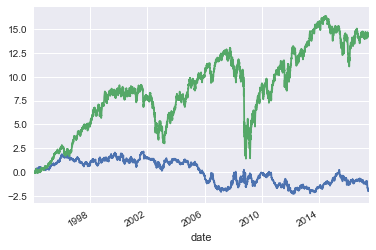

In [50]:
test.groupby('date').sum()['bt_return'].cumsum().plot()
test.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

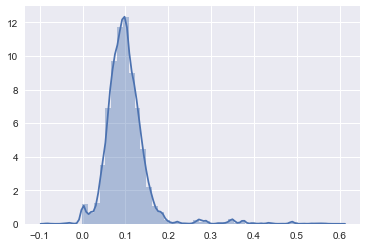

In [319]:
sns.distplot(trace['a_security'][:, 10])

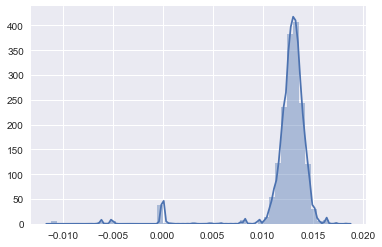

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
